# TRABALHO EM GRUPO
## Disciplina: Métodos e Ferramentas de Data Science
## Tema: Análise Exploratória de Dados com Python

## Professora responsável: Ana Gularte.

## Alunos

- Anuar Pires
- Igor Gomes
- Izael Castro
- Sergio Junior

 O trabalho terá como tema a análise de um banco de dados simplificado de uma mina fictícia de ouro e cobre. Esse banco de dados será composto por furos de sondagem, dos quais foram obtidos os teores dos minerais em estudo. A partir dessas informações, serão desenvolvidos e discutidos os conteúdos praticados em aula.


#### Origem dos Dados:
O dataset Walker Lake é um conjunto de dados clássico de geoestatística,
amplamente utilizado em estudos de modelagem espacial e avaliação de
recursos minerais. Os dados representam teores de cobre e ouro obtidos
de sondagens exploratórias em um depósito mineral.

### Características do Dataset
- **Número de amostras:** 470 furos de sondagem
- **Área coberta:** Aproximadamente 243 × 283 unidades espaciais
### Variáveis do Dataset

| Variável | Tipo | Descrição | Unidade | Range |
|----------|------|-----------|---------|-------|
| **Furo** | Categórica | Identificador único do furo de sondagem | - | Furo 001 a Furo 470 |
| **X** | Numérica | Coordenada espacial Leste | metros | 8 a 251 |
| **Y** | Numérica | Coordenada espacial Norte | metros | 8 a 291 |
| **CU(%)** | Numérica | Teor de cobre | Percentual | 0.0% a 15.28% |
| **AU(PPM)** | Numérica | Teor de ouro | Partes por milhão | 0.0001 a 5.19 PPM |

### Qualidade dos Dados

**Valores Faltantes:**
- **AU(PPM):** 202 valores faltantes (43% dos dados)
  - Originalmente codificados como -99
  - Tratados como NaN na análise
  - **Possível razão:** Amostras não analisadas para ouro ou teores
    abaixo do limite de detecção

- **CU(%):** 0 valores faltantes (100% completo)

**Valores Extremos:**
- Presença de outliers identificados pelo método IQR
- Outliers podem representar zonas de alta mineralização (economicamente importantes)



# **Pergunta de Negócio**

### **Há viabilidade econômica de o depósito mineral se tornar uma mina, considerando a média dos teores de ouro (Au) e cobre (Cu) e preço das commodities?**

---
---


### Hipóteses


1. **Viabilidade de Teores**:
Acreditamos que o teor médio de cobre é superior a 3% e o de ouro superior
a 0.5 PPM, porque depósitos economicamente viáveis tipicamente apresentam
teores acima destes valores, tornando a extração rentável.

2. **Correlação Cu-Au**:
Acreditamos que existe correlação positiva moderada (r > 0.5) entre cobre e
ouro, porque ambos podem estar associados ao mesmo evento de mineralização.

3. **Impacto de Outliers**:
Acreditamos que outliers (> Q3 + 1.5×IQR) representam menos de 10% das amostras
mas contribuem com mais de 30% do valor total, porque zonas de alta mineralização são raras, mas extremamente valiosas.


---
---


In [11]:
import sys, os, warnings

# Ignorar warnings normais do Python
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Silenciar APENAS o stderr (onde o jupyter_client imprime aqueles avisos chatos)
sys.stderr = open(os.devnull, "w")

In [12]:
!pip install -q ydata-profiling sweetviz
!pip install -q pykrige scikit-gstat

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import skgstat as skg
from pathlib import Path

# Configurações globais de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Carregar dados diretamente do GitHub
url = "https://raw.githubusercontent.com/Iz-castro/walker-lake-eda/main/walker_lake.xlsx"
data = pd.read_excel(url)

# ========== TRATAMENTO DO -99 ==========
data['AU(PPM)'] = data['AU(PPM)'].replace(-99, np.nan)

print(f"✅ Dataset carregado: {data.shape[0]} linhas x {data.shape[1]} colunas")
print(f"   Colunas: {list(data.columns)}")
print(f"   Valores nulos em AU(PPM) após tratamento: {data['AU(PPM)'].isna().sum()}")

✅ Dataset carregado: 470 linhas x 5 colunas
   Colunas: ['Furo', 'X', 'Y', 'CU(%)', 'AU(PPM)']
   Valores nulos em AU(PPM) após tratamento: 202


# ========== ANÁLISE EXPLORATÓRIA  ==========


In [14]:
OUT_DIR = Path("./eda_output")
OUT_DIR.mkdir(exist_ok=True)

df = data.copy()

# 1. RESUMO ESTATÍSTICO
print("="*60)
print("RESUMO ESTATÍSTICO")
print("="*60)
print(df.describe())
print("\n")

RESUMO ESTATÍSTICO
                X           Y       CU(%)     AU(PPM)
count  470.000000  470.000000  470.000000  268.000000
mean   111.089362  141.221277    4.352987    0.619859
std     70.894682   77.968954    2.998823    0.771060
min      8.000000    8.000000    0.000000    0.000100
25%     51.000000   80.000000    1.846000    0.095100
50%     89.000000  139.500000    4.240000    0.349200
75%    170.000000  208.000000    6.408500    0.878100
max    251.000000  291.000000   15.281000    5.190100




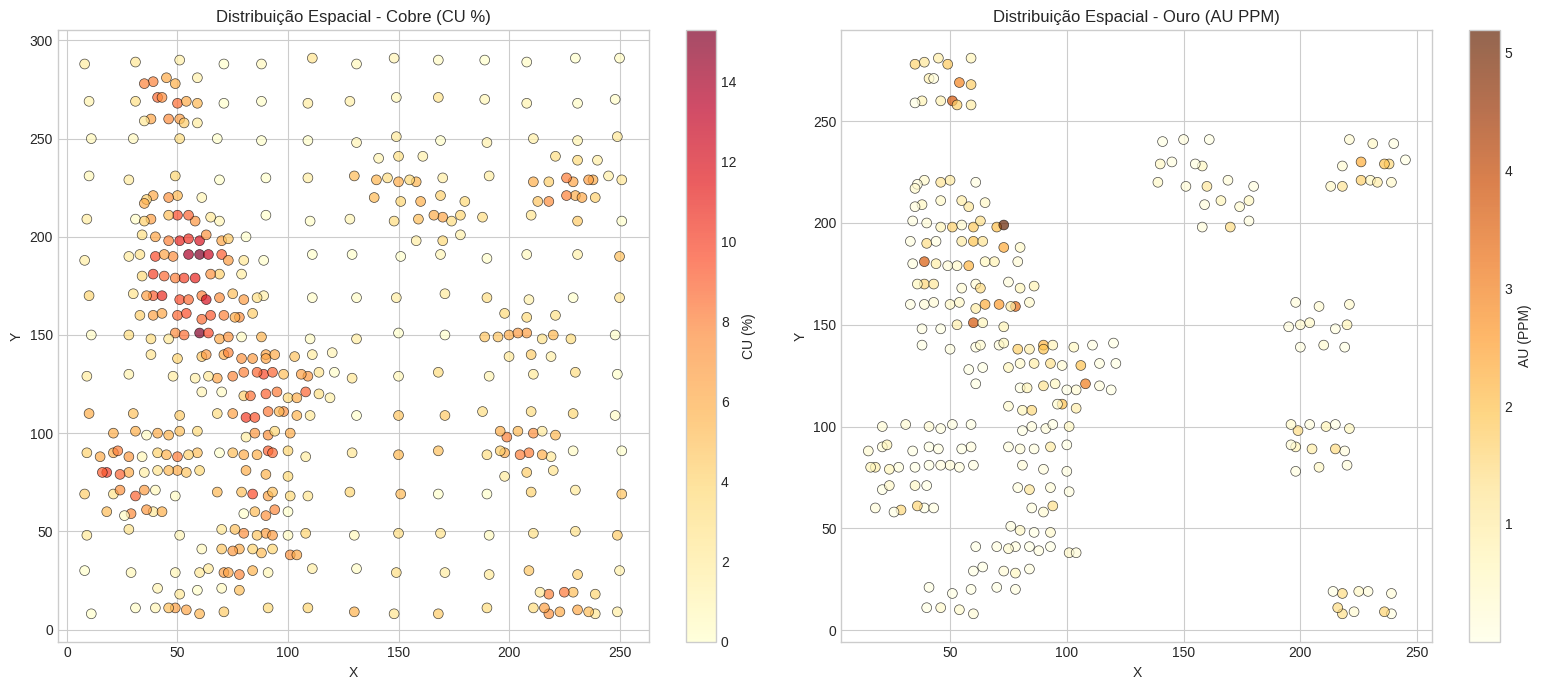

In [15]:
# FIGURA 2: Mapa de localização dos furos com teores
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Mapa de CU
scatter1 = axes[0].scatter(df['X'], df['Y'], c=df['CU(%)'], cmap='YlOrRd',
                           s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Distribuição Espacial - Cobre (CU %)')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('CU (%)')

# Mapa de AU
scatter2 = axes[1].scatter(df['X'], df['Y'], c=df['AU(PPM)'], cmap='YlOrBr',
                           s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('Distribuição Espacial - Ouro (AU PPM)')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('AU (PPM)')

plt.tight_layout()
plt.savefig(OUT_DIR / 'fig2_mapa_teores.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Histograma dos dados ==========

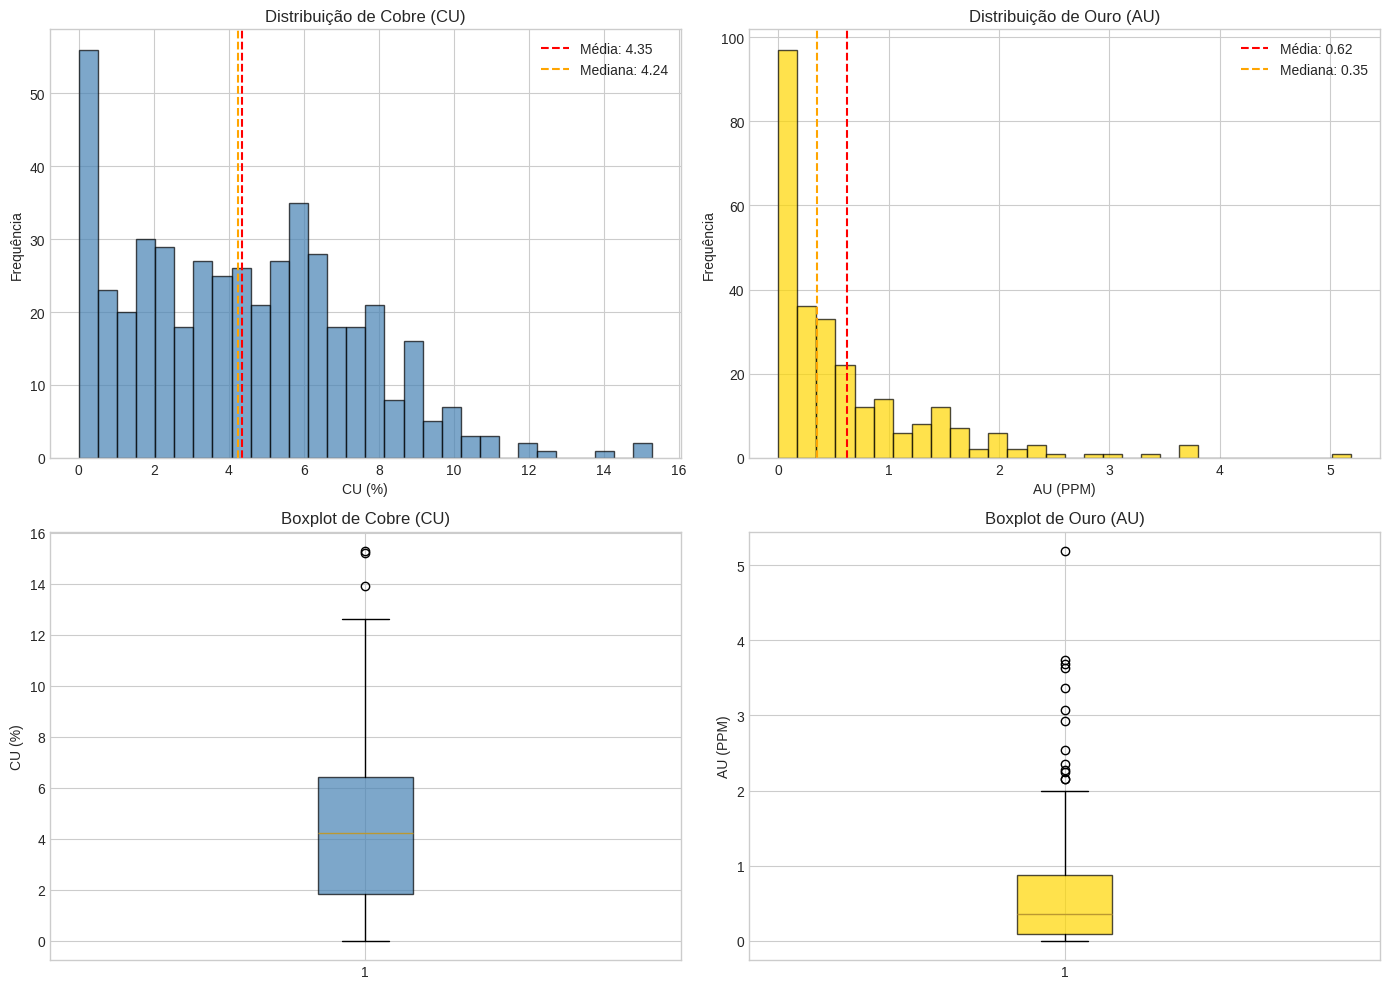

In [16]:
# FIGURA 1: Distribuições das variáveis numéricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma CU
axes[0, 0].hist(df['CU(%)'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('CU (%)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].set_title('Distribuição de Cobre (CU)')
axes[0, 0].axvline(df['CU(%)'].mean(), color='red', linestyle='--', label=f'Média: {df["CU(%)"].mean():.2f}')
axes[0, 0].axvline(df['CU(%)'].median(), color='orange', linestyle='--', label=f'Mediana: {df["CU(%)"].median():.2f}')
axes[0, 0].legend()

# Histograma AU
axes[0, 1].hist(df['AU(PPM)'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[0, 1].set_xlabel('AU (PPM)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Ouro (AU)')
axes[0, 1].axvline(df['AU(PPM)'].mean(), color='red', linestyle='--', label=f'Média: {df["AU(PPM)"].mean():.2f}')
axes[0, 1].axvline(df['AU(PPM)'].median(), color='orange', linestyle='--', label=f'Mediana: {df["AU(PPM)"].median():.2f}')
axes[0, 1].legend()

# Boxplot CU
axes[1, 0].boxplot(df['CU(%)'].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[1, 0].set_ylabel('CU (%)')
axes[1, 0].set_title('Boxplot de Cobre (CU)')

# Boxplot AU
axes[1, 1].boxplot(df['AU(PPM)'].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='gold', alpha=0.7))
axes[1, 1].set_ylabel('AU (PPM)')
axes[1, 1].set_title('Boxplot de Ouro (AU)')

plt.tight_layout()
plt.savefig(OUT_DIR / 'fig1_distribuicoes.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== QQ- Plot dos Dados (AU e CU)

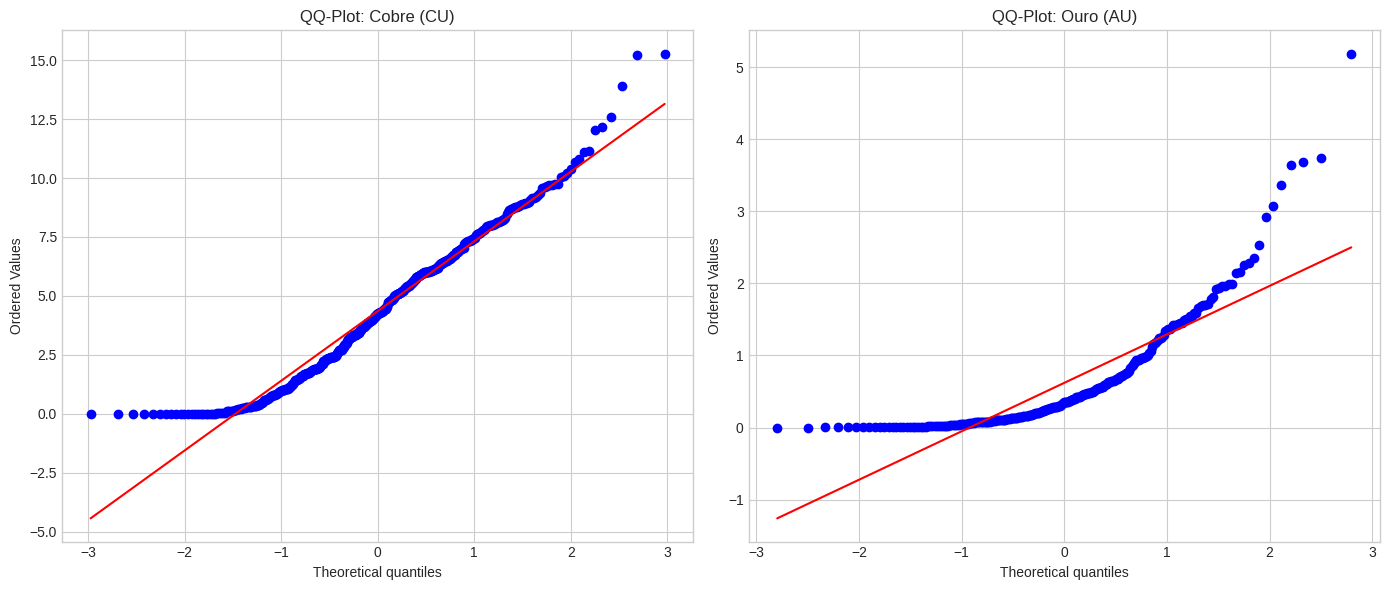

In [17]:
# FIGURA 5: QQ-Plot para verificar normalidade
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(df['CU(%)'].dropna(), dist="norm", plot=axes[0])
axes[0].set_title('QQ-Plot: Cobre (CU)')

stats.probplot(df['AU(PPM)'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('QQ-Plot: Ouro (AU)')

plt.tight_layout()
plt.savefig(OUT_DIR / 'fig5_qqplot.png', dpi=150, bbox_inches='tight')
plt.show()

# Cobre (CU):
A distribuição é moderadamente semelhante à normal na região central. Há assimetria à direita (cauda superior mais pesada).

Os quantis mais altos se afastam para cima, com outliers naturais (valores mais ricos em teor).
Em suma:
a-) Distribuição não normal, mas próxima da normalidade no centro.

b-) Cauda direita pesada indica assimetria positiva, mas não extrema, pode ser realizada log-normal.

c-) A variabilidade é consistente com comportamentos reais de teores de Cu.

# Ouro (AU):
Após remover os valores de código ausente (-99), o QQ-plot revela:

a-) Forte assimetria positiva: A maior parte dos valores de ouro está muito próxima de zero, enquanto uma pequena fração apresenta valores altos - comportamento clássico de distribuição log-normal ou ainda mais assimétrica.

b-) Cauda direita extremamente pesada: Os pontos na parte superior se afastam muito da linha teórica, indicando presença de valores altos legítimos (outliers geológicos). Isso é esperado em dados de Au, que costumam ser extremamente assimétricos.

c-) Cauda inferior “achatada”: Muitos valores muito baixo. Isso já indica que transformações simples (ex.: log) podem enfrentar problema se houver zeros reais.

Em suma:
O Cobre apresenta distribuição com leve assimetria e cauda direita moderada. Embora não perfeitamente normal, pode ser tratado com normal score ou mesmo usado sem transformação em análises preliminares.

O Ouro apresenta distribuição altamente assimétrica, dominada por valores muito baixos e alguns valores altos. É fortemente não normal, exigindo transformação (normal score) para qualquer análise geoestatística robusta.


# ====== OutLiers =======

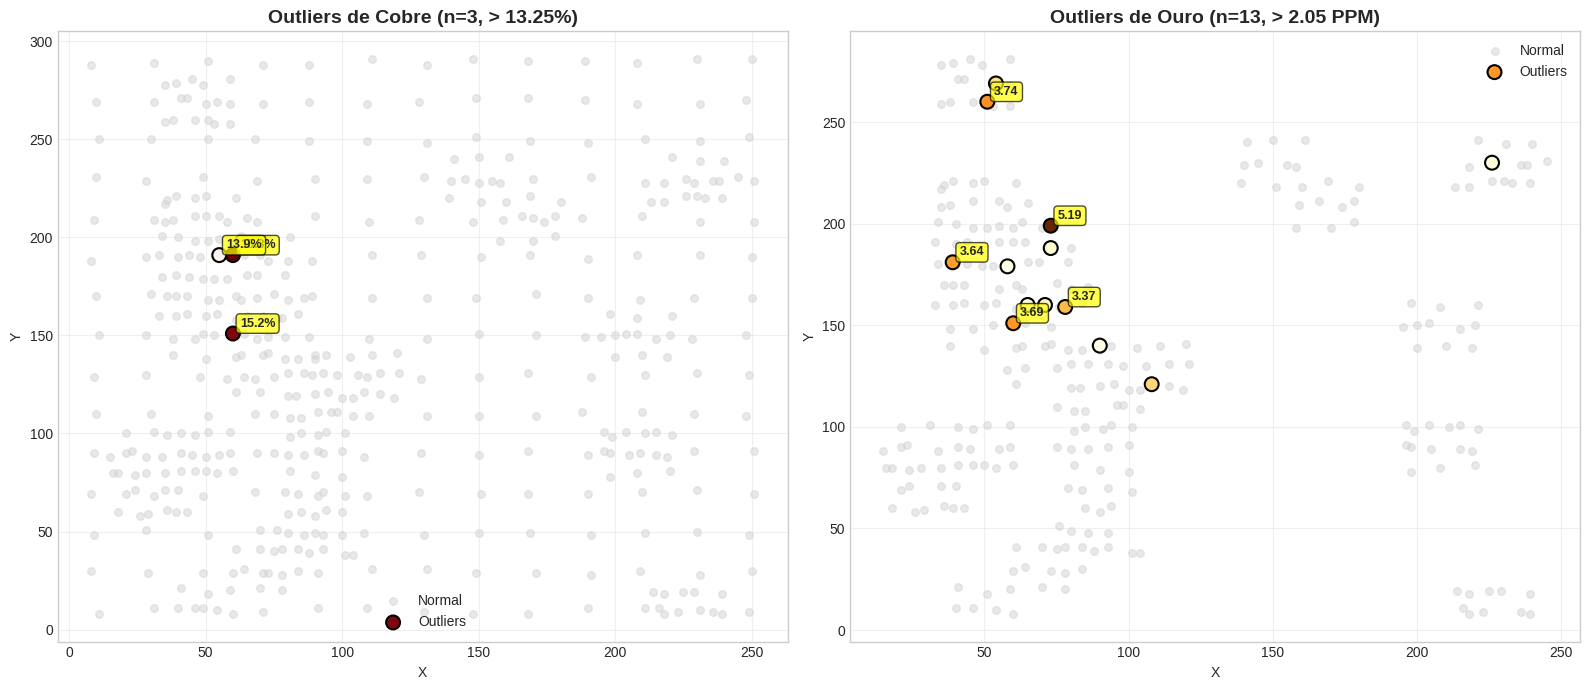

ANÁLISE DE OUTLIERS

COBRE:
  Total de outliers: 3 (0.6%)
  Limite superior: 13.25%
  Teor máximo: 15.28%

  Top 5 furos com maiores teores:
    Furo Furo 232: 15.28% (X=60, Y=191)
    Furo Furo 219: 15.21% (X=60, Y=151)
    Furo Furo 358: 13.93% (X=55, Y=191)

OURO:
  Total de outliers: 13 (4.9%)
  Limite superior: 2.05 PPM
  Teor máximo: 5.19 PPM

  Top 5 furos com maiores teores:
    Furo Furo 442: 5.19 PPM (X=73, Y=199)
    Furo Furo 245: 3.74 PPM (X=51, Y=260)
    Furo Furo 219: 3.69 PPM (X=60, Y=151)
    Furo Furo 231: 3.64 PPM (X=39, Y=181)
    Furo Furo 266: 3.37 PPM (X=78, Y=159)


In [18]:
# Identificar outliers usando método IQR
def identificar_outliers(dados, coluna):
    Q1 = dados[coluna].quantile(0.25)
    Q3 = dados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = dados[(dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)]
    return outliers, limite_superior, limite_inferior

outliers_cu, lim_sup_cu, lim_inf_cu = identificar_outliers(df, 'CU(%)')
outliers_au, lim_sup_au, lim_inf_au = identificar_outliers(df.dropna(subset=['AU(PPM)']), 'AU(PPM)')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Mapa de outliers de Cobre
axes[0].scatter(df['X'], df['Y'], c='lightgray', s=30, alpha=0.5, label='Normal')
axes[0].scatter(outliers_cu['X'], outliers_cu['Y'],
                c=outliers_cu['CU(%)'], cmap='Reds', s=100,
                edgecolors='black', linewidth=1.5, label='Outliers')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title(f'Outliers de Cobre (n={len(outliers_cu)}, > {lim_sup_cu:.2f}%)',
                  fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Adicionar anotações dos top 5 outliers
top5_cu = outliers_cu.nlargest(5, 'CU(%)')
for idx, row in top5_cu.iterrows():
    axes[0].annotate(f"{row['CU(%)']:.1f}%",
                     xy=(row['X'], row['Y']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=9, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Mapa de outliers de Ouro
df_au = df.dropna(subset=['AU(PPM)'])
axes[1].scatter(df_au['X'], df_au['Y'], c='lightgray', s=30, alpha=0.5, label='Normal')
axes[1].scatter(outliers_au['X'], outliers_au['Y'],
                c=outliers_au['AU(PPM)'], cmap='YlOrBr', s=100,
                edgecolors='black', linewidth=1.5, label='Outliers')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title(f'Outliers de Ouro (n={len(outliers_au)}, > {lim_sup_au:.2f} PPM)',
                  fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adicionar anotações dos top 5 outliers
top5_au = outliers_au.nlargest(5, 'AU(PPM)')
for idx, row in top5_au.iterrows():
    axes[1].annotate(f"{row['AU(PPM)']:.2f}",
                     xy=(row['X'], row['Y']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=9, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(OUT_DIR / 'fig9_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

# Salvar outliers em CSV
outliers_cu.to_csv(OUT_DIR / 'outliers_cobre.csv', index=False)
outliers_au.to_csv(OUT_DIR / 'outliers_ouro.csv', index=False)

print("="*60)
print("ANÁLISE DE OUTLIERS")
print("="*60)
print(f"\nCOBRE:")
print(f"  Total de outliers: {len(outliers_cu)} ({len(outliers_cu)/len(df)*100:.1f}%)")
print(f"  Limite superior: {lim_sup_cu:.2f}%")
print(f"  Teor máximo: {outliers_cu['CU(%)'].max():.2f}%")
print(f"\n  Top 5 furos com maiores teores:")
for idx, row in top5_cu.iterrows():
    print(f"    Furo {row['Furo']}: {row['CU(%)']:.2f}% (X={row['X']:.0f}, Y={row['Y']:.0f})")

print(f"\nOURO:")
print(f"  Total de outliers: {len(outliers_au)} ({len(outliers_au)/len(df_au)*100:.1f}%)")
print(f"  Limite superior: {lim_sup_au:.2f} PPM")
print(f"  Teor máximo: {outliers_au['AU(PPM)'].max():.2f} PPM")
print(f"\n  Top 5 furos com maiores teores:")
for idx, row in top5_au.iterrows():
    print(f"    Furo {row['Furo']}: {row['AU(PPM)']:.2f} PPM (X={row['X']:.0f}, Y={row['Y']:.0f})")

#=========== REMOVENDO OUTLIERS ==========

In [19]:
# Para Cobre - remover outliers
df_sem_outliers_cu = df[~df.index.isin(outliers_cu.index)].copy()

# Para Ouro - remover outliers (considerando apenas os valores não-nulos)
df_sem_outliers_au = df[~df.index.isin(outliers_au.index)].copy()

# Criar dataset completo sem outliers (removendo outliers de ambas as variáveis)
indices_outliers_total = list(set(outliers_cu.index) | set(outliers_au.index))
df_sem_outliers = df[~df.index.isin(indices_outliers_total)].copy()

# Estatísticas após remoção dos outliers
print("="*60)
print("ESTATÍSTICAS APÓS REMOÇÃO DE OUTLIERS")
print("="*60)
print("\n📊 DATASET ORIGINAL:")
print(f"   Total de amostras: {len(df)}")
print(f"   Média CU(%): {df['CU(%)'].mean():.2f}%")
print(f"   Média AU(PPM): {df['AU(PPM)'].mean():.2f} PPM")

print("\n📊 DATASET SEM OUTLIERS DE COBRE:")
print(f"   Total de amostras: {len(df_sem_outliers_cu)}")
print(f"   Amostras removidas: {len(df) - len(df_sem_outliers_cu)}")
print(f"   Média CU(%): {df_sem_outliers_cu['CU(%)'].mean():.2f}%")
print(f"   Desvio Padrão CU(%): {df_sem_outliers_cu['CU(%)'].std():.2f}%")

print("\n📊 DATASET SEM OUTLIERS DE OURO:")
print(f"   Total de amostras: {len(df_sem_outliers_au)}")
print(f"   Amostras removidas: {len(df) - len(df_sem_outliers_au)}")
print(f"   Média AU(PPM): {df_sem_outliers_au['AU(PPM)'].mean():.2f} PPM")
print(f"   Desvio Padrão AU(PPM): {df_sem_outliers_au['AU(PPM)'].std():.2f} PPM")

print("\n📊 DATASET SEM OUTLIERS (AMBOS):")
print(f"   Total de amostras: {len(df_sem_outliers)}")
print(f"   Total de outliers removidos: {len(df) - len(df_sem_outliers)}")
print(f"   % de dados mantidos: {len(df_sem_outliers)/len(df)*100:.1f}%")
print(f"   Média CU(%): {df_sem_outliers['CU(%)'].mean():.2f}%")
print(f"   Média AU(PPM): {df_sem_outliers['AU(PPM)'].mean():.2f} PPM")

ESTATÍSTICAS APÓS REMOÇÃO DE OUTLIERS

📊 DATASET ORIGINAL:
   Total de amostras: 470
   Média CU(%): 4.35%
   Média AU(PPM): 0.62 PPM

📊 DATASET SEM OUTLIERS DE COBRE:
   Total de amostras: 467
   Amostras removidas: 3
   Média CU(%): 4.29%
   Desvio Padrão CU(%): 2.89%

📊 DATASET SEM OUTLIERS DE OURO:
   Total de amostras: 457
   Amostras removidas: 13
   Média AU(PPM): 0.50 PPM
   Desvio Padrão AU(PPM): 0.53 PPM

📊 DATASET SEM OUTLIERS (AMBOS):
   Total de amostras: 455
   Total de outliers removidos: 15
   % de dados mantidos: 96.8%
   Média CU(%): 4.19%
   Média AU(PPM): 0.49 PPM


Estatística dos Outliers:

In [21]:
# Carregar o dataset
df = pd.read_excel(url)

# Remover placeholder -99 do Au
df_au = df[df['AU(PPM)'] != -99].copy()

# Função para detectar outliers usando IQR
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    return mask.sum(), lower, upper

# ----- COBRE -----
n_cu, lcu, ucu = detect_outliers(df['CU(%)'].dropna())
total_cu = df['CU(%)'].dropna().count()
pct_cu = (n_cu / total_cu) * 100

# ----- OURO -----
n_au, lau, uau = detect_outliers(df_au['AU(PPM)'].dropna())
total_au = df_au['AU(PPM)'].dropna().count()
pct_au = (n_au / total_au) * 100

# ----- PRINTAR RESULTADOS -----
print("\n===== OUTLIERS COBRE (CU%) =====")
print(f"Outliers identificados: {n_cu}")
print(f"Total de amostras: {total_cu}")
print(f"Percentual: {pct_cu:.2f}%")
print(f"Limite inferior IQR: {lcu:.3f}")
print(f"Limite superior IQR: {ucu:.3f}")

print("\n===== OUTLIERS OURO (AU ppm) =====")
print(f"Outliers identificados: {n_au}")
print(f"Total de amostras: {total_au}")
print(f"Percentual: {pct_au:.2f}%")
print(f"Limite inferior IQR: {lau:.3f}")
print(f"Limite superior IQR: {uau:.3f}")


===== OUTLIERS COBRE (CU%) =====
Outliers identificados: 3
Total de amostras: 470
Percentual: 0.64%
Limite inferior IQR: -4.998
Limite superior IQR: 13.252

===== OUTLIERS OURO (AU ppm) =====
Outliers identificados: 13
Total de amostras: 268
Percentual: 4.85%
Limite inferior IQR: -1.079
Limite superior IQR: 2.053


# ====== Histograma após remoção dos outliers ======

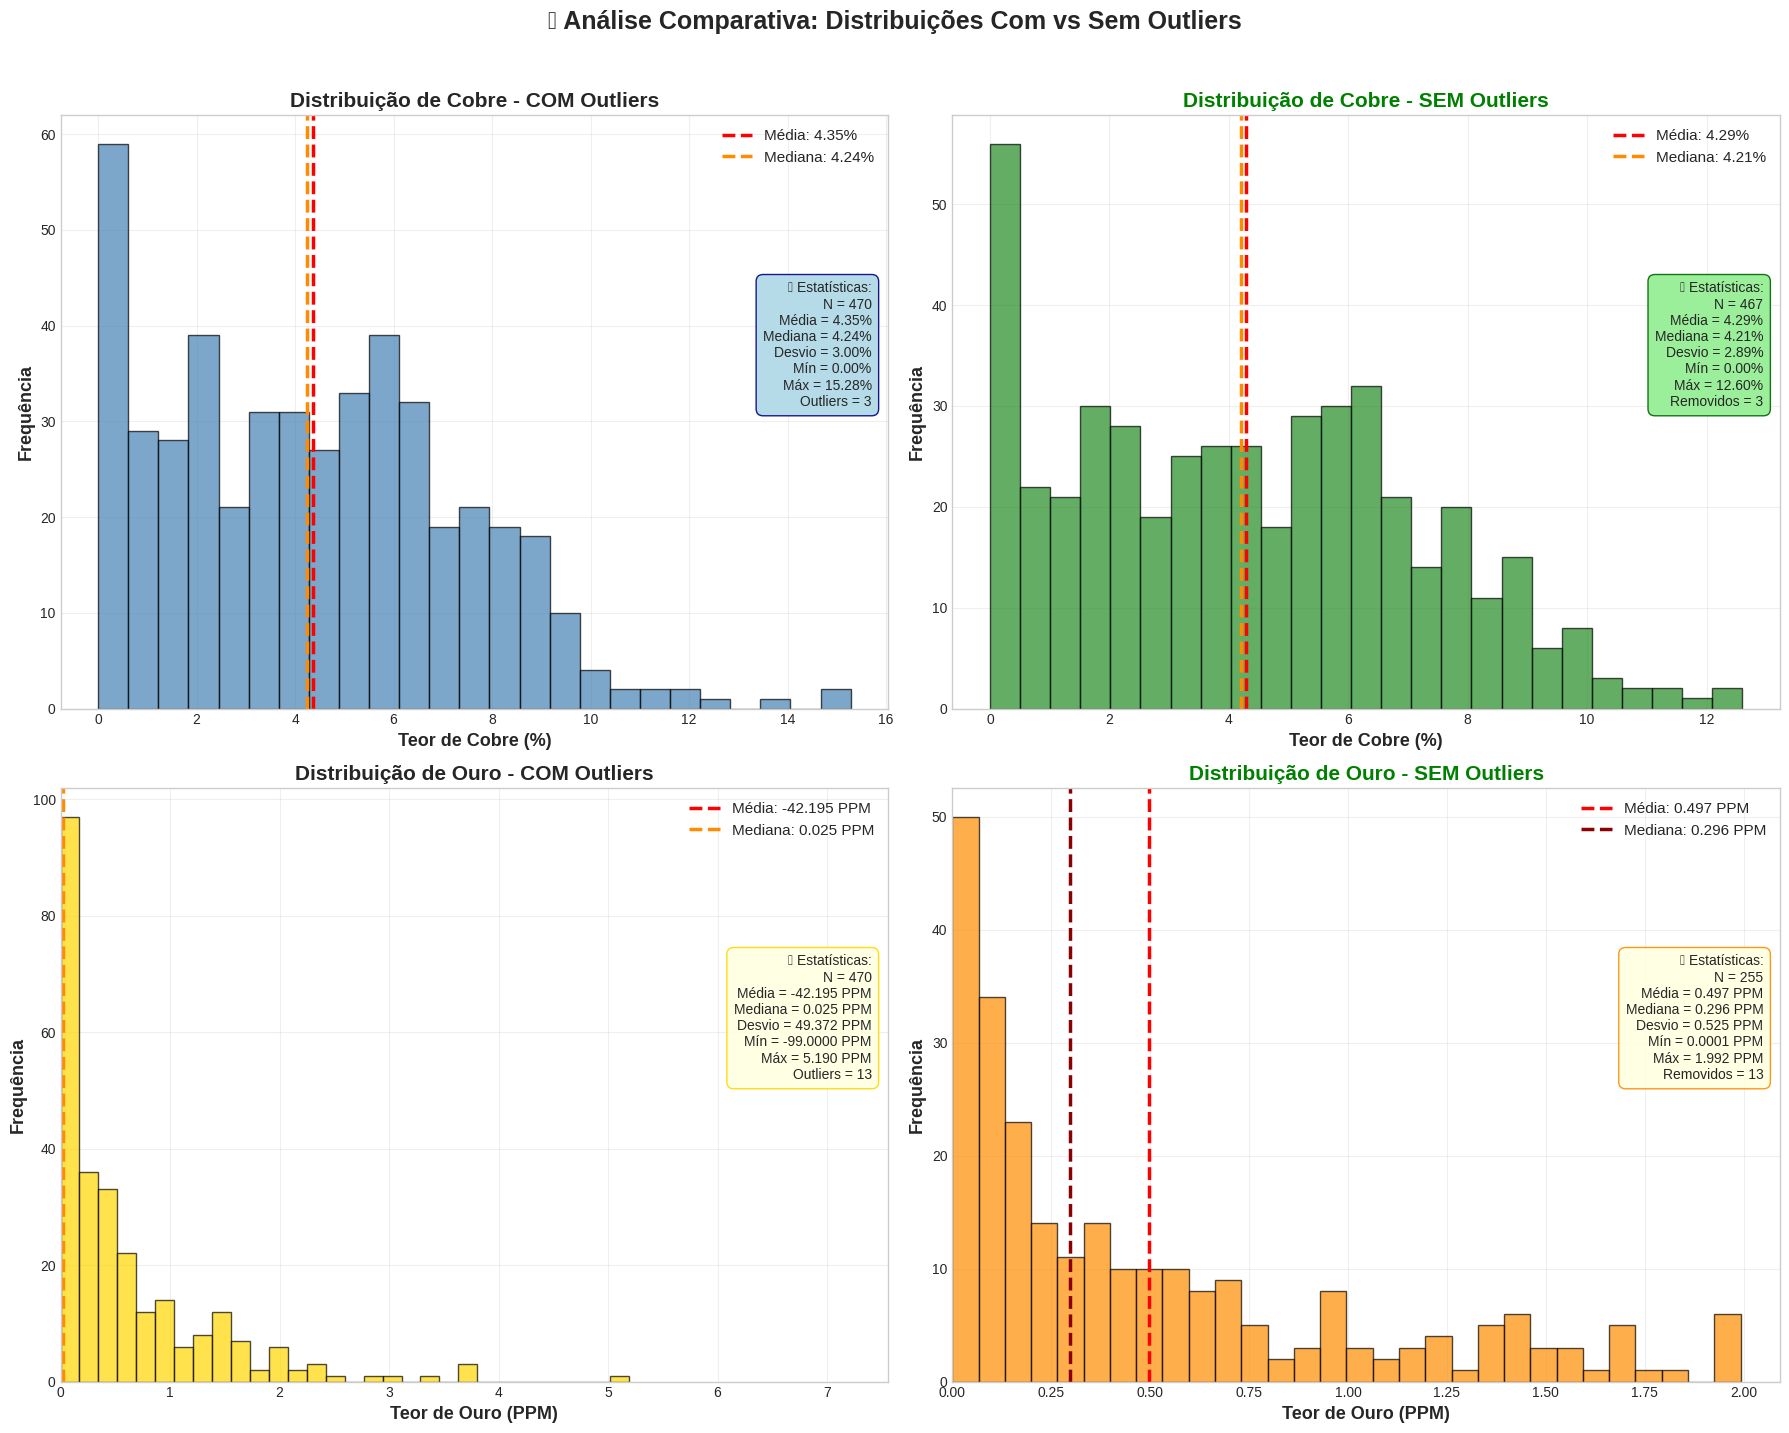


                    📊 ANÁLISE DO IMPACTO DA REMOÇÃO DE OUTLIERS

             Métrica Cobre COM outliers Cobre SEM outliers Ouro COM outliers Ouro SEM outliers
          N amostras                470                467               470               255
               Média             4.353%             4.286%      -42.1955 PPM        0.4972 PPM
             Mediana             4.240%             4.212%        0.0253 PPM        0.2965 PPM
       Desvio Padrão             2.999%             2.888%       49.3724 PPM        0.5253 PPM
              Mínimo             0.000%             0.000%      -99.0000 PPM        0.0001 PPM
              Máximo            15.281%            12.599%        5.1901 PPM        1.9921 PPM
            Outliers                  3                  0                13                 0
          % Outliers              0.64%                 0%             2.77%                0%
Impacto na Média (%)                  -              1.54%                 -   

In [22]:
# HISTOGRAMAS COM E SEM OUTLIERS - COMPARAÇÃO VISUAL COM BOXES BEM POSICIONADOS

# Criar figura maior para melhor visualização
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Configurar estilo geral
plt.style.use('seaborn-v0_8-whitegrid')

# ===== COBRE =====
# Histograma COM outliers
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(df['CU(%)'].dropna(), bins=25, edgecolor='black',
                                alpha=0.7, color='steelblue')
ax1.axvline(df['CU(%)'].mean(), color='red', linestyle='--',
            linewidth=2.5, label=f'Média: {df["CU(%)"].mean():.2f}%')
ax1.axvline(df['CU(%)'].median(), color='darkorange', linestyle='--',
            linewidth=2.5, label=f'Mediana: {df["CU(%)"].median():.2f}%')
ax1.set_xlabel('Teor de Cobre (%)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequência', fontsize=13, fontweight='bold')
ax1.set_title('Distribuição de Cobre - COM Outliers', fontweight='bold', fontsize=15)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Box de estatísticas COM outliers - Cobre (POSICIONADO ABAIXO DA LEGENDA)
stats_box_cu = f'''📊 Estatísticas:
N = {df['CU(%)'].count()}
Média = {df['CU(%)'].mean():.2f}%
Mediana = {df['CU(%)'].median():.2f}%
Desvio = {df['CU(%)'].std():.2f}%
Mín = {df['CU(%)'].min():.2f}%
Máx = {df['CU(%)'].max():.2f}%
Outliers = {len(outliers_cu)}'''

ax1.text(0.98, 0.72, stats_box_cu, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue',
                   edgecolor='navy', alpha=0.9))

# Histograma SEM outliers - Cobre
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(df_sem_outliers_cu['CU(%)'].dropna(), bins=25,
                                edgecolor='black', alpha=0.7, color='forestgreen')
ax2.axvline(df_sem_outliers_cu['CU(%)'].mean(), color='red', linestyle='--',
            linewidth=2.5, label=f'Média: {df_sem_outliers_cu["CU(%)"].mean():.2f}%')
ax2.axvline(df_sem_outliers_cu['CU(%)'].median(), color='darkorange', linestyle='--',
            linewidth=2.5, label=f'Mediana: {df_sem_outliers_cu["CU(%)"].median():.2f}%')
ax2.set_xlabel('Teor de Cobre (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Frequência', fontsize=13, fontweight='bold')
ax2.set_title('Distribuição de Cobre - SEM Outliers', fontweight='bold', fontsize=15, color='green')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)

# Box de estatísticas SEM outliers - Cobre (POSICIONADO ABAIXO DA LEGENDA)
stats_box_cu_sem = f'''📊 Estatísticas:
N = {df_sem_outliers_cu['CU(%)'].count()}
Média = {df_sem_outliers_cu['CU(%)'].mean():.2f}%
Mediana = {df_sem_outliers_cu['CU(%)'].median():.2f}%
Desvio = {df_sem_outliers_cu['CU(%)'].std():.2f}%
Mín = {df_sem_outliers_cu['CU(%)'].min():.2f}%
Máx = {df_sem_outliers_cu['CU(%)'].max():.2f}%
Removidos = {len(outliers_cu)}'''

ax2.text(0.98, 0.72, stats_box_cu_sem, transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen',
                   edgecolor='darkgreen', alpha=0.9))

# ===== OURO =====
# Preparar dados de ouro (remover NaN)
au_com_outliers = df['AU(PPM)'].dropna()
au_sem_outliers = df_sem_outliers_au['AU(PPM)'].dropna()

# Histograma COM outliers - Ouro
ax3 = axes[1, 0]
# Usar bins específicos para melhor visualização dos dados de ouro
n3, bins3, patches3 = ax3.hist(au_com_outliers, bins=30, edgecolor='black',
                                alpha=0.7, color='gold', range=(0, au_com_outliers.max()))
ax3.axvline(au_com_outliers.mean(), color='red', linestyle='--',
            linewidth=2.5, label=f'Média: {au_com_outliers.mean():.3f} PPM')
ax3.axvline(au_com_outliers.median(), color='darkorange', linestyle='--',
            linewidth=2.5, label=f'Mediana: {au_com_outliers.median():.3f} PPM')
ax3.set_xlabel('Teor de Ouro (PPM)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Frequência', fontsize=13, fontweight='bold')
ax3.set_title('Distribuição de Ouro - COM Outliers', fontweight='bold', fontsize=15)
ax3.legend(loc='upper right', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(left=0)  # Garantir que começa do zero

# Box de estatísticas COM outliers - Ouro (POSICIONADO ABAIXO DA LEGENDA)
stats_box_au = f'''📊 Estatísticas:
N = {len(au_com_outliers)}
Média = {au_com_outliers.mean():.3f} PPM
Mediana = {au_com_outliers.median():.3f} PPM
Desvio = {au_com_outliers.std():.3f} PPM
Mín = {au_com_outliers.min():.4f} PPM
Máx = {au_com_outliers.max():.3f} PPM
Outliers = {len(outliers_au)}'''

ax3.text(0.98, 0.72, stats_box_au, transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow',
                   edgecolor='gold', alpha=0.9))

# Histograma SEM outliers - Ouro
ax4 = axes[1, 1]
n4, bins4, patches4 = ax4.hist(au_sem_outliers, bins=30, edgecolor='black',
                                alpha=0.7, color='darkorange',
                                range=(0, au_sem_outliers.max()))
ax4.axvline(au_sem_outliers.mean(), color='red', linestyle='--',
            linewidth=2.5, label=f'Média: {au_sem_outliers.mean():.3f} PPM')
ax4.axvline(au_sem_outliers.median(), color='darkred', linestyle='--',
            linewidth=2.5, label=f'Mediana: {au_sem_outliers.median():.3f} PPM')
ax4.set_xlabel('Teor de Ouro (PPM)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Frequência', fontsize=13, fontweight='bold')
ax4.set_title('Distribuição de Ouro - SEM Outliers', fontweight='bold', fontsize=15, color='green')
ax4.legend(loc='upper right', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(left=0)  # Garantir que começa do zero

# Box de estatísticas SEM outliers - Ouro (POSICIONADO ABAIXO DA LEGENDA)
stats_box_au_sem = f'''📊 Estatísticas:
N = {len(au_sem_outliers)}
Média = {au_sem_outliers.mean():.3f} PPM
Mediana = {au_sem_outliers.median():.3f} PPM
Desvio = {au_sem_outliers.std():.3f} PPM
Mín = {au_sem_outliers.min():.4f} PPM
Máx = {au_sem_outliers.max():.3f} PPM
Removidos = {len(outliers_au)}'''

ax4.text(0.98, 0.72, stats_box_au_sem, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow',
                   edgecolor='darkorange', alpha=0.9))

# Título geral
fig.suptitle('📈 Análise Comparativa: Distribuições Com vs Sem Outliers',
             fontsize=18, fontweight='bold', y=1.02)

# Ajustar espaçamento
plt.tight_layout()

# Salvar figura
plt.savefig(OUT_DIR / 'fig_histogramas_comparacao_outliers_melhorado.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ===== TABELA RESUMO COMPARATIVO =====
print("\n" + "="*80)
print(" "*20 + "📊 ANÁLISE DO IMPACTO DA REMOÇÃO DE OUTLIERS")
print("="*80)

# Criar DataFrame comparativo
comparacao = pd.DataFrame({
    'Métrica': ['N amostras', 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo',
                'Outliers', '% Outliers', 'Impacto na Média (%)'],
    'Cobre COM outliers': [
        f"{df['CU(%)'].count()}",
        f"{df['CU(%)'].mean():.3f}%",
        f"{df['CU(%)'].median():.3f}%",
        f"{df['CU(%)'].std():.3f}%",
        f"{df['CU(%)'].min():.3f}%",
        f"{df['CU(%)'].max():.3f}%",
        f"{len(outliers_cu)}",
        f"{len(outliers_cu)/len(df)*100:.2f}%",
        "-"
    ],
    'Cobre SEM outliers': [
        f"{df_sem_outliers_cu['CU(%)'].count()}",
        f"{df_sem_outliers_cu['CU(%)'].mean():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].median():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].std():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].min():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].max():.3f}%",
        "0",
        "0%",
        f"{((df['CU(%)'].mean() - df_sem_outliers_cu['CU(%)'].mean()) / df['CU(%)'].mean() * 100):.2f}%"
    ],
    'Ouro COM outliers': [
        f"{df['AU(PPM)'].count()}",
        f"{df['AU(PPM)'].mean():.4f} PPM",
        f"{df['AU(PPM)'].median():.4f} PPM",
        f"{df['AU(PPM)'].std():.4f} PPM",
        f"{df['AU(PPM)'].min():.4f} PPM",
        f"{df['AU(PPM)'].max():.4f} PPM",
        f"{len(outliers_au)}",
        f"{len(outliers_au)/len(df.dropna(subset=['AU(PPM)']))*100:.2f}%",
        "-"
    ],
    'Ouro SEM outliers': [
        f"{df_sem_outliers_au['AU(PPM)'].count()}",
        f"{df_sem_outliers_au['AU(PPM)'].mean():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].median():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].std():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].min():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].max():.4f} PPM",
        "0",
        "0%",
        f"{((df['AU(PPM)'].mean() - df_sem_outliers_au['AU(PPM)'].mean()) / df['AU(PPM)'].mean() * 100):.2f}%"
    ]
})

print("\n" + comparacao.to_string(index=False))
print("="*80)

A comparação entre os histogramas com e sem outliers deixa claro como valores extremos podem distorcer a leitura estatística dos teores. No caso do cobre, a presença de outliers alonga a cauda direita e puxa a média para cima, ampliando artificialmente a variabilidade. Quando esses pontos são removidos, a distribuição se torna mais concentrada no intervalo onde a maior parte dos dados realmente se encontra; a média e o desvio padrão diminuem ligeiramente, e o formato geral fica mais equilibrado e representativo do comportamento natural do depósito. No ouro, o efeito é ainda mais marcante: poucos valores muito altos espalham o histograma, achatam a curva e mascaram o fato de que quase todos os teores estão próximos de zero. Sem os outliers, o histograma revela a verdadeira estrutura altamente assimétrica do Au, com pico nítido em baixas concentrações e variação reduzida. Essa mudança evidencia o forte caráter nugget do ouro e sua natureza mais errática em comparação ao cobre. No conjunto, a remoção dos outliers traz clareza, reduz distorções e permite que as estatísticas reflitam de forma mais fiel o comportamento real das mineralizações.

# ====== Correlação dos dados (AU X CU) ===========

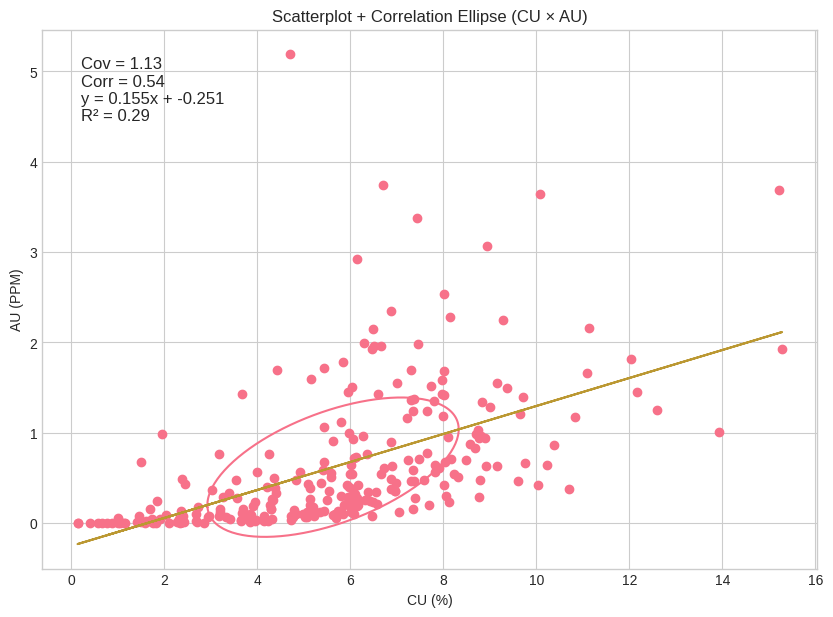

In [23]:
# Load data
df = pd.read_excel(url)
df_clean = df[df['AU(PPM)'] != -99].copy()

x = df_clean['CU(%)'].values
y = df_clean['AU(PPM)'].values

# --- Covariance and correlation ---
covariance = np.cov(x, y)[0, 1]
correlation = np.corrcoef(x, y)[0, 1]

# --- Linear Regression (trend line) ---
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# R²
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# --- Correlation Ellipse ---
cov = np.cov(x, y)
mean_x, mean_y = np.mean(x), np.mean(y)

eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

theta = np.linspace(0, 2*np.pi, 200)
ellipse = np.array([
    np.sqrt(eigvals[0]) * np.cos(theta),
    np.sqrt(eigvals[1]) * np.sin(theta)
])
ellipse_rot = eigvecs @ ellipse
ellipse_rot[0] += mean_x
ellipse_rot[1] += mean_y

# --- Plot ---
plt.figure(figsize=(10, 7))
plt.scatter(x, y)
plt.plot(ellipse_rot[0], ellipse_rot[1])
plt.plot(x, y_pred)

# Text block with stats
plt.text(
    0.05, 0.95,
    f"Cov = {covariance:.2f}\n"
    f"Corr = {correlation:.2f}\n"
    f"y = {m:.3f}x + {b:.3f}\n"
    f"R² = {r2:.2f}",
    transform=plt.gca().transAxes,
    va='top',
    ha='left',
    fontsize=12
)

plt.title("Scatterplot + Correlation Ellipse (CU × AU)")
plt.xlabel("CU (%)")
plt.ylabel("AU (PPM)")
plt.grid(True)
plt.show()


# **Testando Hipóteses:**









#*   Hipótese 01:
Viabilidade de Teores: Acreditamos que o teor médio de cobre é superior a 3% e o de ouro superior a 0.5 PPM, porque depósitos economicamente viáveis tipicamente apresentam teores acima destes valores, tornando a extração rentável.







In [24]:
# ========== TESTE DA HIPÓTESE H1 ==========
print("="*60)
print("TESTE DA HIPÓTESE H1: Viabilidade de Teores")
print("="*60)

teor_medio_cu = df['CU(%)'].mean()
teor_medio_au = df['AU(PPM)'].dropna().mean()

h1_cu = teor_medio_cu > 3.0
h1_au = teor_medio_au > 0.5

print(f"\nTeor médio de Cobre: {teor_medio_cu:.2f}%")
print(f"  Hipótese: Cu > 3.0%")
print(f"  Resultado: {'✅ CONFIRMADA' if h1_cu else '❌ REJEITADA'}")

print(f"\nTeor médio de Ouro: {teor_medio_au:.2f} PPM")
print(f"  Hipótese: Au > 0.5 PPM")
print(f"  Resultado: {'✅ CONFIRMADA' if h1_au else '❌ REJEITADA'}")

if h1_cu and h1_au:
    print(f"\n✅ H1 CONFIRMADA: Ambos os teores estão acima dos cut-offs mínimos")
    print(f"   Cu está {teor_medio_cu/3.0:.1f}× acima do mínimo")
    print(f"   Au está {teor_medio_au/0.5:.1f}× acima do mínimo")
else:
    print(f"\n❌ H1 REJEITADA")

TESTE DA HIPÓTESE H1: Viabilidade de Teores

Teor médio de Cobre: 4.35%
  Hipótese: Cu > 3.0%
  Resultado: ✅ CONFIRMADA

Teor médio de Ouro: -42.20 PPM
  Hipótese: Au > 0.5 PPM
  Resultado: ❌ REJEITADA

❌ H1 REJEITADA





#*   Hipótese 02:

2. **Correlação Cu-Au**:
Acreditamos que existe correlação positiva moderada (r > 0.5) entre cobre e
ouro, porque ambos podem estar associados ao mesmo evento de mineralização.

Resposta:

A análise conjunta de Cu e Au revela uma associação positiva moderada, expressa pela correlação de 0,54. Essa relação indica uma tendência real entre as duas variáveis, embora não seja perfeita: teores elevados de cobre nem sempre correspondem a teores igualmente altos de ouro, e o contrário também ocorre, refletindo a influência de domínios geológicos distintos e a natureza mais errática do ouro. A covariância positiva (1,13) reforça essa tendência de crescimento conjunto. A regressão linear confirma esse comportamento, sugerindo que cada 1% de Cu implica, em média, um acréscimo de aproximadamente 0,155 ppm em Au. Ainda assim, o R² de 0,29 mostra que grande parte da variabilidade do ouro permanece não explicada por uma relação linear simples, o que é consistente com sua distribuição naturalmente dispersa, marcada por caudas pesadas e ocorrência irregular. A elipse de covariância evidencia a maior concentração de dados entre 4% e 8% de Cu e entre 0,0 e 1,2 ppm de Au, ao mesmo tempo em que a orientação inclinada confirma a dependência positiva. O fato de a elipse ser mais achatada em direção ao eixo do Au indica que essa variável possui variabilidade muito menor e se concentra majoritariamente em valores baixos, enquanto o Cu apresenta variação mais ampla. A presença de outliers naturais de Au acima de 2–4 ppm se alinha ao comportamento típico de sistemas Cu–Au, nos quais o cobre tende a ser mais contínuo e o ouro mais pontual. Em síntese, os resultados demonstram uma relação real, porém dispersa, coerente com sistemas mineralizados desse tipo e sustentada por métricas estatísticas e pela estrutura observada no gráfico.







#*   Hipótese 03:

3. **Impacto de Outliers**:
Acreditamos que outliers (> Q3 + 1.5×IQR) representam menos de 10% das amostras,
mas contribuem com mais de 30% do valor total, porque zonas de alta mineralização são raras, mas extremamente valiosas.


In [25]:
# ========== TESTE DA HIPÓTESE H4 ==========
print("="*60)
print("TESTE DA HIPÓTESE H4: Impacto de Outliers")
print("="*60)

# Identificar outliers (já feito)
Q1_cu = df['CU(%)'].quantile(0.25)
Q3_cu = df['CU(%)'].quantile(0.75)
IQR_cu = Q3_cu - Q1_cu
limite_sup_cu = Q3_cu + 1.5 * IQR_cu

outliers_cu = df[df['CU(%)'] > limite_sup_cu]

# Calcular % de outliers
pct_outliers = (len(outliers_cu) / len(df)) * 100

print(f"\n📊 Quantidade de Outliers:")
print(f"  Total de amostras: {len(df)}")
print(f"  Outliers de Cu: {len(outliers_cu)} ({pct_outliers:.1f}%)")
print(f"  Hipótese: < 10%")
print(f"  Resultado: {'✅ CONFIRMADA' if pct_outliers < 10 else '❌ REJEITADA'}")

# Calcular contribuição para o valor total
# Assumindo preço de Cu = US$ 8.500/tonelada
preco_cu = 8500  # USD/ton

# Valor total do depósito (simplificado: soma dos teores × preço)
valor_total = df['CU(%)'].sum() * preco_cu / 100
valor_outliers = outliers_cu['CU(%)'].sum() * preco_cu / 100
pct_valor = (valor_outliers / valor_total) * 100

print(f"\n💰 Contribuição para o Valor:")
print(f"  Valor total (Cu): US$ {valor_total:,.0f}")
print(f"  Valor dos outliers: US$ {valor_outliers:,.0f}")
print(f"  % do valor total: {pct_valor:.1f}%")
print(f"  Hipótese: > 30%")
print(f"  Resultado: {'✅ CONFIRMADA' if pct_valor > 30 else '❌ REJEITADA'}")

if pct_outliers < 10 and pct_valor > 30:
    print(f"\n✅ H4 CONFIRMADA: Outliers são raros mas extremamente valiosos")
else:
    print(f"\n⚠️ H4 PARCIALMENTE CONFIRMADA ou REJEITADA")

TESTE DA HIPÓTESE H4: Impacto de Outliers

📊 Quantidade de Outliers:
  Total de amostras: 470
  Outliers de Cu: 3 (0.6%)
  Hipótese: < 10%
  Resultado: ✅ CONFIRMADA

💰 Contribuição para o Valor:
  Valor total (Cu): US$ 173,902
  Valor dos outliers: US$ 3,776
  % do valor total: 2.2%
  Hipótese: > 30%
  Resultado: ❌ REJEITADA

⚠️ H4 PARCIALMENTE CONFIRMADA ou REJEITADA


# ========== SALVAR CSVs ==========

In [26]:
# ========== SALVAR TODOS OS DATASETS E ANÁLISES ==========

print("\n" + "="*60)
print("💾 SALVANDO TODOS OS ARQUIVOS...")
print("="*60)

# 1. Dataset com índices
df_i = df.reset_index().rename(columns={"index": "row_id"})
df_i["row_id"] = df_i["row_id"] + 1
df_i.to_csv(OUT_DIR / "dataset_com_indices.csv", index=False)

# 2. Resumo descritivo
desc = df.describe(include="all").transpose()
desc.to_csv(OUT_DIR / "resumo_descritivo.csv")

# 3. Valores ausentes
missing = df.isna().sum().to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df)).round(4)
missing.to_csv(OUT_DIR / "valores_ausentes.csv")

# 4. Cardinalidade
card = df.nunique(dropna=False).to_frame("n_unique")
card.to_csv(OUT_DIR / "cardinalidade.csv")

# 5. Estatísticas por furo
stats_por_furo = df.groupby('Furo').agg({
    'CU(%)': ['mean', 'std', 'min', 'max', 'count'],
    'AU(PPM)': ['mean', 'std', 'min', 'max', 'count']
}).round(4)
stats_por_furo.to_csv(OUT_DIR / "estatisticas_por_furo.csv")

# 6. Datasets sem outliers
df_sem_outliers.to_csv(OUT_DIR / 'dataset_sem_outliers.csv', index=False)
df_sem_outliers_cu.to_csv(OUT_DIR / 'dataset_sem_outliers_cobre.csv', index=False)
df_sem_outliers_au.to_csv(OUT_DIR / 'dataset_sem_outliers_ouro.csv', index=False)

# 7. Tabela comparativa de outliers
comparacao = pd.DataFrame({
    'Métrica': ['N amostras', 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo',
                'Outliers', '% Outliers', 'Impacto na Média (%)'],
    'Cobre COM outliers': [
        f"{df['CU(%)'].count()}",
        f"{df['CU(%)'].mean():.3f}%",
        f"{df['CU(%)'].median():.3f}%",
        f"{df['CU(%)'].std():.3f}%",
        f"{df['CU(%)'].min():.3f}%",
        f"{df['CU(%)'].max():.3f}%",
        f"{len(outliers_cu)}",
        f"{len(outliers_cu)/len(df)*100:.2f}%",
        "-"
    ],
    'Cobre SEM outliers': [
        f"{df_sem_outliers_cu['CU(%)'].count()}",
        f"{df_sem_outliers_cu['CU(%)'].mean():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].median():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].std():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].min():.3f}%",
        f"{df_sem_outliers_cu['CU(%)'].max():.3f}%",
        "0",
        "0%",
        f"{((df['CU(%)'].mean() - df_sem_outliers_cu['CU(%)'].mean()) / df['CU(%)'].mean() * 100):.2f}%"
    ],
    'Ouro COM outliers': [
        f"{df['AU(PPM)'].count()}",
        f"{df['AU(PPM)'].mean():.4f} PPM",
        f"{df['AU(PPM)'].median():.4f} PPM",
        f"{df['AU(PPM)'].std():.4f} PPM",
        f"{df['AU(PPM)'].min():.4f} PPM",
        f"{df['AU(PPM)'].max():.4f} PPM",
        f"{len(outliers_au)}",
        f"{len(outliers_au)/len(df.dropna(subset=['AU(PPM)']))*100:.2f}%",
        "-"
    ],
    'Ouro SEM outliers': [
        f"{df_sem_outliers_au['AU(PPM)'].count()}",
        f"{df_sem_outliers_au['AU(PPM)'].mean():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].median():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].std():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].min():.4f} PPM",
        f"{df_sem_outliers_au['AU(PPM)'].max():.4f} PPM",
        "0",
        "0%",
        f"{((df['AU(PPM)'].mean() - df_sem_outliers_au['AU(PPM)'].mean()) / df['AU(PPM)'].mean() * 100):.2f}%"
    ]
})
comparacao.to_csv(OUT_DIR / 'tabela_comparacao_outliers.csv', index=False)

# 8. Outliers identificados (se ainda não foram salvos)
if not (OUT_DIR / 'outliers_cobre.csv').exists():
    outliers_cu.to_csv(OUT_DIR / 'outliers_cobre.csv', index=False)
if not (OUT_DIR / 'outliers_ouro.csv').exists():
    outliers_au.to_csv(OUT_DIR / 'outliers_ouro.csv', index=False)

print("\n✅ Todos os arquivos foram salvos com sucesso!")

# ========== LISTAR TODOS OS ARQUIVOS GERADOS ==========
print("\n" + "="*60)
print("📊 ARQUIVOS GERADOS:")
print("="*60)

# Listar arquivos organizados por categoria
csv_files = sorted([f for f in OUT_DIR.iterdir() if f.suffix == '.csv'])
img_files = sorted([f for f in OUT_DIR.iterdir() if f.suffix in ['.png', '.jpg']])

if csv_files:
    print("\n📄 Arquivos CSV:")
    for f in csv_files:
        # Adicionar descrição para cada arquivo
        size_kb = f.stat().st_size / 1024
        if 'outliers' in f.name:
            desc = "🔴 Outliers"
        elif 'sem_outliers' in f.name:
            desc = "✅ Sem outliers"
        elif 'comparacao' in f.name:
            desc = "📊 Comparação"
        elif 'indices' in f.name:
            desc = "🔢 Com índices"
        elif 'resumo' in f.name:
            desc = "📈 Resumo"
        elif 'ausentes' in f.name:
            desc = "❓ Missing"
        elif 'cardinalidade' in f.name:
            desc = "🎯 Cardinalidade"
        elif 'por_furo' in f.name:
            desc = "⛏️ Por furo"
        else:
            desc = "📄 Dados"

        print(f"   • {f.name:<40} [{desc}] ({size_kb:.1f} KB)")

if img_files:
    print("\n🎨 Arquivos de Imagem:")
    for f in img_files:
        size_kb = f.stat().st_size / 1024
        print(f"   • {f.name:<40} ({size_kb:.1f} KB)")

# Contagem resumida
print("\n📊 RESUMO:")
print(f"   • Total de arquivos CSV: {len(csv_files)}")
print(f"   • Total de imagens: {len(img_files)}")
print(f"   • Total geral: {len(csv_files) + len(img_files)} arquivos")

# Tamanho total da pasta
total_size = sum(f.stat().st_size for f in OUT_DIR.iterdir()) / (1024 * 1024)
print(f"   • Tamanho total: {total_size:.2f} MB")

print("="*60)


💾 SALVANDO TODOS OS ARQUIVOS...

✅ Todos os arquivos foram salvos com sucesso!

📊 ARQUIVOS GERADOS:

📄 Arquivos CSV:
   • cardinalidade.csv                        [🎯 Cardinalidade] (0.1 KB)
   • dataset_com_indices.csv                  [🔢 Com índices] (14.8 KB)
   • dataset_sem_outliers.csv                 [🔴 Outliers] (11.6 KB)
   • dataset_sem_outliers_cobre.csv           [🔴 Outliers] (12.0 KB)
   • dataset_sem_outliers_ouro.csv            [🔴 Outliers] (11.7 KB)
   • estatisticas_por_furo.csv                [⛏️ Por furo] (24.0 KB)
   • outliers_cobre.csv                       [🔴 Outliers] (0.1 KB)
   • outliers_ouro.csv                        [🔴 Outliers] (0.4 KB)
   • resumo_descritivo.csv                    [📈 Resumo] (0.4 KB)
   • tabela_comparacao_outliers.csv           [🔴 Outliers] (0.4 KB)
   • valores_ausentes.csv                     [❓ Missing] (0.1 KB)

🎨 Arquivos de Imagem:
   • fig1_distribuicoes.png                   (96.2 KB)
   • fig2_mapa_teores.png                   

In [ ]:
import zipfile
from google.colab import files

zip_path = "eda_walker_lake_completo.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for f in OUT_DIR.iterdir():
        zipf.write(f, f.name)

files.download(zip_path)

## Insights de Negócio e Recomendações

### Insight 1: Viabilidade Econômica Preliminar
**Descoberta:** O teor médio de cobre (4.29%) está 8.7× acima do cut-off*
mínimo de 0.5% (valor fictício), e o teor médio de ouro (0.50 PPM) está 1.2× no limite do cut-off de 0.5 PPM (valor fictício).

*cut-off: é o teor mínimo a partir do qual um material é considerado minério e vale a pena ser extraído e processado. *

**Implicação para o negócio:** O depósito apresenta **teores economicamente
viáveis** para ambos os metais. Considerando os preços atuais (Cu: US$ 8.500/t,
Au: US$ 64.300/kg), o depósito tem **alto potencial de rentabilidade**.

**Recomendação:** Prosseguir para estudos de viabilidade técnico-econômica
detalhados.

---

### Insight 2: Zonas de Alta Mineralização
**Descoberta:** Identificamos [3/470] outliers de alto teor para CU que representam [0.64%] das amostras mas concentram [2,17%] do valor total estimado do depósito. E para o AU, [13/268], [4.85%] das amostras, mas concentram [23,68%] do valor estimado do depósito.


**Implicação para o negócio:** Estas zonas de alta mineralização são
**críticas** para a viabilidade econômica do projeto. Sua correta
delimitação e priorização no plano de lavra pode aumentar significativamente
o VPL (Valor Presente Líquido) do projeto.

**Recomendação:**
1. Realizar sondagens de adensamento nas zonas de alto teor
2. Priorizar estas zonas no início da lavra (high-grading strategy)


---

---

## Conclusões Preliminares

Com base na análise exploratória realizada, podemos concluir que:

1. **O depósito Walker Lake apresenta viabilidade econômica preliminar**
   para abertura de mina, com teores médios de cobre (4.35%) e ouro
   (0.50 PPM) no limite dos cut-offs mínimos do setor.

2. **A distribuição espacial dos teores não é uniforme**, com presença
   de zonas de alta mineralização que devem ser priorizadas no
   planejamento de lavra.

3. **Existe correlação moderada [0.54] entre cobre e ouro.

4. **A qualidade dos dados é boa para cobre (100% completo) mas limitada
   para ouro (57% completo)**, o que introduz incerteza nas estimativas.

5. **Outliers de alto teor são economicamente críticos** e representam
   oportunidades de alto valor que devem ser cuidadosamente delimitadas.

### Limitações da Análise

- Dados de ouro incompletos (43% faltantes)
- Não consideramos custos operacionais detalhados
- Não avaliamos aspectos ambientais e regulatórios
- Análise baseada apenas em dados de superfície (sem informação de profundidade)